In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, asin, sqrt
from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline

In [21]:
spray = pd.read_csv('./data/west_nile/input/spray.csv')
weather = pd.read_csv('./data/west_nile/input/weather.csv')
train = pd.read_csv('./data/west_nile/input/train.csv')
sample = pd.read_csv('./data/west_nile/input/SampleSubmission.csv')
test = pd.read_csv('./data/west_nile/input/test.csv')

In [22]:
def dist(lat1, lon1, lat2, lon2):
    '''Calculates the distance between two lat-long points.'''
    
    R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))
    return R * c

In [23]:
def EDA(df):
    null_vals = df.isnull().sum()[df.isnull().sum() > 0] 
    shape = df.shape
    dtypes = df.dtypes
    print('Nulls:', null_vals)
    print('Shape:', shape)
    print('Data Types:', dtypes)

In [24]:
print(EDA(train))
print(EDA(test))
print(EDA(spray))
print(EDA(weather))
print(EDA(sample))

Nulls: Series([], dtype: int64)
Shape: (10506, 12)
Data Types: Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object
None
Nulls: Series([], dtype: int64)
Shape: (116293, 11)
Data Types: Id                          int64
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
dtype: object
None
Nulls: Time    584
dtype: int64
Shape: (14835, 4)
Dat

In [25]:
# date is an object an int
def convert_date(df):
    df['Date'] = pd.to_datetime(df['Date'])

In [26]:
convert_date(train)
convert_date(test)
convert_date(weather)

In [27]:
#spray date
spray['Date'] = pd.to_datetime(spray['Date'])
spray['am_pm'] = spray['Time'].apply(lambda x: str(x).split()[-1])
spray['Time'] = spray['Time'].apply(lambda x: str(x).split()[0])
spray['Time'] = pd.to_datetime(spray['Time'], format = '%H:%M:%S')

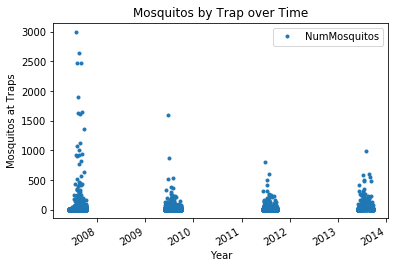

In [28]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time')
plt.xlabel('Year')
plt.ylabel('Mosquitos at Traps');

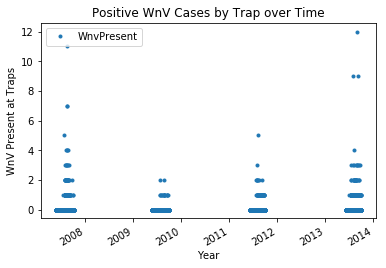

In [29]:
#plotted WNV incidents by trap
train[['Date', 'Trap','WnvPresent']].groupby(by = ['Date','Trap'])['Date','Trap','WnvPresent'] \
    .sum().reset_index().sort_values('WnvPresent', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Positive WnV Cases by Trap over Time')
plt.xlabel('Year')
plt.ylabel('WnV Present at Traps');

In [30]:
def closest_station(df):
    station1lat = 41.995
    station1long = -87.933
    station2lat = 41.786
    station2long = -87.752 

    df['Station'] = 1

    for i in range(df.shape[0]):
        if dist(station1lat, station1long, df.loc[i, 'Latitude'], df.loc[i, 'Longitude']) > dist(station2lat, station2long, df.loc[i, 'Latitude'], df.loc[i, 'Longitude']):
            df.loc[i,'Station'] = 2

In [31]:
#assign a station to traps in train and test data
closest_station(train)
closest_station(test)

In [32]:
train.head(3)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,1


In [34]:
weather.drop(columns = ['SeaLevel','CodeSum', 'Sunrise', 'Sunset','Depart','Depth','Water1', 'SnowFall', 'Cool', 'Heat','StnPressure', 'AvgSpeed','ResultSpeed','ResultDir'], inplace = True)

In [35]:
#filling in missing(M) and trace(T)
weather_dataset = weather.columns.tolist()

for col in weather_dataset:
    for row in range(weather.shape[0]):
        if weather.loc[row, col] == 'M' or weather.loc[row, col] == '  T':
            weather.loc[row, col] = weather.loc[row - 1, col]

In [36]:
weather_object_dtypes = ['Tavg', 'WetBulb', 'PrecipTotal']

for col in weather_object_dtypes:
    weather[col] = pd.to_numeric(weather[col])

In [37]:
weather.head(3)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal
0,1,2007-05-01,83,50,67,51,56,0.0
1,2,2007-05-01,84,52,68,51,57,0.0
2,1,2007-05-02,59,42,51,42,47,0.0


In [38]:
#merge weather data with train and test data

train = train.merge(weather, how = 'left', on = ['Date','Station'])
test = test.merge(weather, how = 'left', on = ['Date', 'Station'])

In [39]:
# Drop num mosquitos column, not present in test set
train.drop(columns = 'NumMosquitos', inplace = True)

In [40]:
def mosquito(df):
    #split wnv transmitting mosquito species lines into separate columns
    df['CULEX PIPIENS'] = 0
    df['CULEX RESTUANS'] = 0
    
    for row in range(df.shape[0]):
        if df.loc[row, 'Species'] == 'CULEX PIPIENS/RESTUANS':
            df.loc[row, 'CULEX PIPIENS'] == 1
            df.loc[row, 'CULEX RESTUANS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX PIPIENS':
            df.loc[row, 'CULEX PIPIENS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX RESTUANS':
            df.loc[row, 'CULEX RESTUANS'] == 1
            
    
    df.drop(columns = ['Species'], inplace = True)

In [41]:
#make dummies for mosquito species
mosquito(train)
mosquito(test)

In [43]:
train['wet_temp'] = train['PrecipTotal']*train['Tavg']
train['wet_temp_roll'] = train['wet_temp'].rolling(3).mean()
train['wet_temp_roll'].fillna(0, inplace = True)
train['wet_temp_roll_shift14'] = train['wet_temp_roll'].shift(14)
train['wet_temp_roll_shift14'].fillna(0, inplace = True)

In [44]:
test['wet_temp'] = test['PrecipTotal']*test['Tavg']
test['wet_temp_roll'] = test['wet_temp'].rolling(3).mean()
test['wet_temp_roll'].fillna(0, inplace = True)
test['wet_temp_roll_shift14'] = test['wet_temp_roll'].shift(14)
test['wet_temp_roll_shift14'].fillna(0, inplace = True)

In [45]:
train = pd.get_dummies(train, columns = ['Block', 'Trap'])
test = pd.get_dummies(test, columns = ['Block', 'Trap'])

In [46]:
def date_split(df):
    #breaking week, month, and year into separate columns
    
    df['Week'] = df['Date'].dt.week
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    #drop date column
    df.drop(columns = 'Date', inplace = True)

    #get dummies
    return pd.get_dummies(df, columns = ['Week'])
    return pd.get_dummies(df, columns = ['Month'])
    return pd.get_dummies(df, columns = ['Year'])

In [47]:
train.drop(columns = ['Date','Address','Street', 'AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy'], inplace = True)\

test.drop(columns = ['Date','Address','Street','AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy'], inplace = True)

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.utils import resample

In [159]:
X = train.drop(columns = 'WnvPresent')
y = train['WnvPresent']

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [161]:
traindata = X_train.merge(pd.DataFrame(y_train), how = 'left', right_index = True, left_index = True)
train_majority = traindata[traindata['WnvPresent'] == 0]
train_minority = traindata[traindata['WnvPresent'] == 1]
train_minority_upsampled = resample(train_minority, 
                                     replace = True, 
                                     n_samples = train_majority.shape[0],
                                     random_state = 42)

train_data_upsampled = pd.concat([train_majority, train_minority_upsampled])
X_train = train_data_upsampled.drop(columns = 'WnvPresent')
y_train = train_data_upsampled['WnvPresent']

In [162]:
y_train.value_counts()

1    6968
0    6968
Name: WnvPresent, dtype: int64

In [163]:
def drop_columns(df1, df2):
    #drop columns in either test/train that are not in the other
    
    df1cols = df1.columns.tolist()
    df2cols = df2.columns.tolist()
    
    notindf1cols = []
    notindf2cols = []
    
    for col in df1cols:
        if col not in df2cols:
            notindf2cols.append(col)
    
    for col in df2cols:
        if col not in df1cols:
            notindf1cols.append(col)
            
    df1.drop(columns = notindf2cols, inplace = True)
    df2.drop(columns = notindf1cols, inplace = True)

In [142]:
drop_columns(test, X_test)
drop_columns(X_train, X_test)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [164]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
adamodel = AdaBoostClassifier(n_estimators=100) 
ada_scores = cross_val_score(adamodel, X_train, y_train, cv=5)
adamodel.fit(X_train,y_train)
adamodel.score(X_train,y_train)
y_preds = model.predict_proba(X_test)
metrics.roc_auc_score(y_test,y_preds)

In [118]:
xgmodel= xgb.XGBClassifier(seed= 42)
eval_set = [(X_train, y_train), (X_test, y_test)]
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, cv = 5, n_jobs = -1)
xgmodel.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

In [119]:
xgmodel.score(X_test, y_test)

In [120]:
test_names = test.columns.tolist()
xg_importances = pd.DataFrame(sorted(zip(test_names, xgmodel.feature_importances_), reverse = True), columns = ['Variable', 'Importance']).set_index('Variable')

In [121]:
xg_importances.sort_values(by = 'Importance', ascending = False).iloc[:20,:].plot(kind = 'bar')
plt.title('XGBoost Feature Importances')

In [122]:
from sklearn.metrics import classification_report , confusion_matrix

print(classification_report(y_test, xgmodel.predict(X_test)))
print(confusion_matrix(y_test, xgmodel.predict(X_test)))

In [165]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

In [167]:
#testnames = test.columns.tolist()

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

test = ss.transform(test)
model = Sequential()

In [168]:
#network topolgy
input_units = X_train.shape[1]
hidden_units = 200

model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu',
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(hidden_units, 
               activation = 'relu',))
model.add(Dense(1, activation = 'sigmoid'))

In [169]:
#compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['binary_accuracy'])

In [173]:
#train the model
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = 20, 
                   batch_size = None, 
                   verbose = 1)

Train on 13936 samples, validate on 3152 samples
Epoch 1/20
13936/13936 [==============================] - 1s 90us/step - loss: 0.2323 - binary_accuracy: 0.9292 - val_loss: 0.5546 - val_binary_accuracy: 0.8414
Epoch 2/20
13936/13936 [==============================] - 1s 91us/step - loss: 0.2322 - binary_accuracy: 0.9298 - val_loss: 0.5937 - val_binary_accuracy: 0.8204
Epoch 3/20
13936/13936 [==============================] - 1s 84us/step - loss: 0.2292 - binary_accuracy: 0.9298 - val_loss: 0.5688 - val_binary_accuracy: 0.8388
Epoch 4/20
13936/13936 [==============================] - 1s 83us/step - loss: 0.2231 - binary_accuracy: 0.9318 - val_loss: 0.5500 - val_binary_accuracy: 0.8458
Epoch 5/20
13936/13936 [==============================] - 1s 83us/step - loss: 0.2271 - binary_accuracy: 0.9309 - val_loss: 0.5345 - val_binary_accuracy: 0.8420
Epoch 6/20
13936/13936 [==============================] - 1s 84us/step - loss: 0.2345 - binary_accuracy: 0.9262 - val_loss: 0.5761 - val_binary_ac

In [172]:
#predicting values for submission
#submission = pd.DataFrame(xgmodel.predict_proba(test)[:,1], columns = ['WnvPresent'])
submission = pd.DataFrame(model.predict_proba(test), columns = ['WnvPresent'])
submission.set_index(np.arange(1, test.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.to_csv('./submission.csv', index = False)